# <font style="color:rgb(50,120,229)">Application: Sunglass Filter </font>

In this section, we will create a simple and fun application using some of the topics we have learned so far.

We will put a sunglass on the face of elon musk and make him look cool ( as if he doesn't look so already! ).

![](https://www.dropbox.com/s/4w87z3mkr75lpa0/musk_with_sunglass.png?dl=1)

In [2]:
# Import libraries
import cv2
import numpy as np
from dataPath import DATA_PATH
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## <font style="color:rgb(50,120,229)">Load the Face and sunglass Images </font>
First of all, we will need the two images:
1. Imag of Elon Musk we have been using throughout
1. A png image of a sunglass with an alpha channel

Let us load the images and have a look at them.

image Dimension =(100, 300, 4)


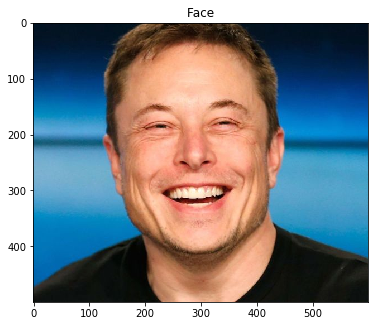

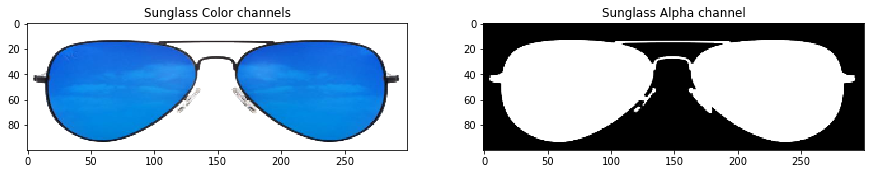

In [4]:
# Load the Face Image
faceImagePath = DATA_PATH + "/images/musk.jpg"
faceImage = cv2.imread(faceImagePath)

plt.imshow(faceImage[:,:,::-1]);plt.title("Face")

# Load the Sunglass image with Alpha channel
# (http://pluspng.com/sunglass-png-1104.html)
glassimagePath = DATA_PATH + "/images/sunglass.png"
glassPNG = cv2.imread(glassimagePath,cv2.IMREAD_UNCHANGED)


# Resize the image to fit over the eye region
glassPNG = cv2.resize(glassPNG,(300,100))
print("image Dimension ={}".format(glassPNG.shape))

# Separate the Color and alpha channels
glassBGR = glassPNG[:,:,0:3]
glassMask1 = glassPNG[:,:,3]

# Display the images for clarity
plt.figure(figsize=[15,15])


plt.subplot(121);plt.imshow(glassBGR[:,:,::-1]);
plt.title('Sunglass Color channels');


plt.subplot(122);plt.imshow(glassMask1);
plt.title('Sunglass Alpha channel');

Text(0.5, 1.0, 'Mask Alpha Channel')

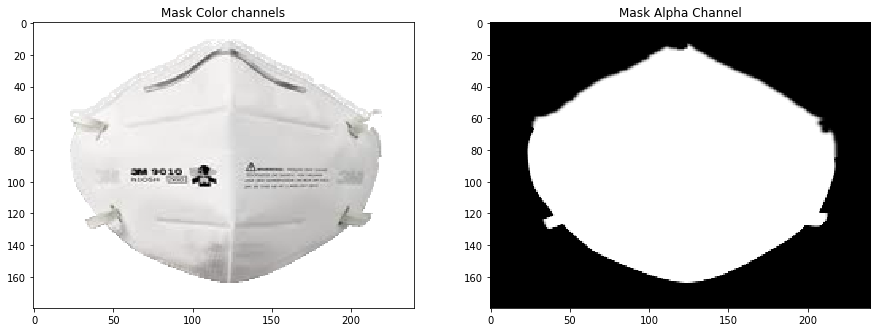

In [5]:
# Load in the mask with all 4 channels
maskPNG = cv2.imread("mask.png", cv2.IMREAD_UNCHANGED)

# resize the image to fit over the mouth (dont care about aspect ratio)
maskPNG = cv2.resize(maskPNG, (240, 180))

# Separate the aplha channel with the BGR Channel
maskAlpha = maskPNG[:,:,3]
maskBGR = maskPNG[:,:,0:3]

plt.figure(figsize=[15,15])
plt.subplot(121)
plt.imshow(maskBGR);
plt.title('Mask Color channels');
plt.subplot(122)
plt.imshow(maskAlpha)
plt.title('Mask Alpha Channel')

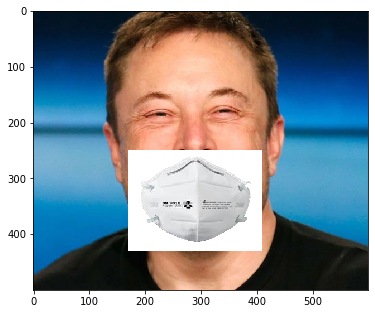

In [6]:
# Here we will use Naive replace to just insert the mask over Elon's Face (sorry Elon)

# Make a copy of the original image
facecopy = faceImage.copy()

facecopy[250:430,170:410] = maskBGR

# don't forget to reverse the bgr to rgb
plt.imshow(facecopy[:,:,::-1])

Text(0.5, 1.0, 'Augmented Mouth and Mask')

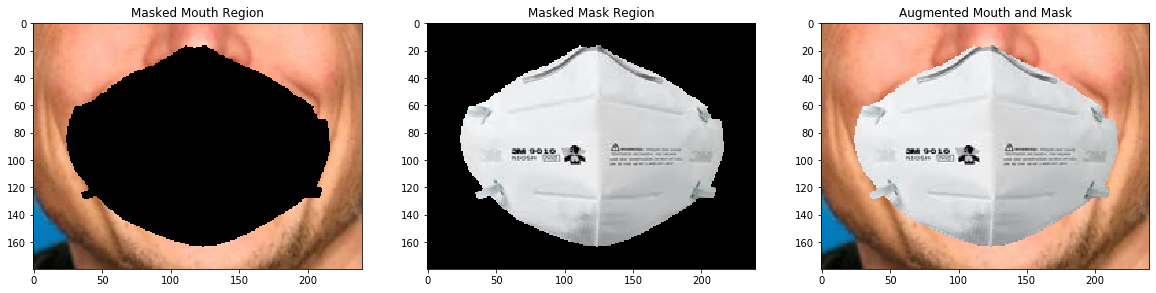

In [7]:
# Now lets actually use the alpha mask to appench this mask to elon's face correctly

# Make the dimensions of the mask same as the input image.
# Since Face Image is a 3-channel image, we create a 3 channel image for the mask
maskAlphaFinal = cv2.merge((maskAlpha,maskAlpha,maskAlpha))

# Make the values [0,1] since we are using arithmetic operations
maskAlphaFinal = np.uint8(maskAlphaFinal/255)

# Make a copy
faceWithMaskArithmetic = faceImage.copy()

# Get the eye region from the face image
mouthROI = faceWithMaskArithmetic[220:400,170:410]

# Use the mask to create the masked eye region
maskedMouth = cv2.multiply(mouthROI,(1-maskAlphaFinal))

# Use the mask to create the masked sunglass region
maskedMask = cv2.multiply(maskBGR,maskAlphaFinal)

# Combine the Sunglass in the Eye Region to get the augmented image
maskRoiFinal = cv2.add(maskedMouth, maskedMask)

# Display the intermediate results
plt.figure(figsize=[20,20])
plt.subplot(131);plt.imshow(maskedMouth[...,::-1]);plt.title("Masked Mouth Region")
plt.subplot(132);plt.imshow(maskedMask[...,::-1]);plt.title("Masked Mask Region")
plt.subplot(133);plt.imshow(maskRoiFinal[...,::-1]);plt.title("Augmented Mouth and Mask")

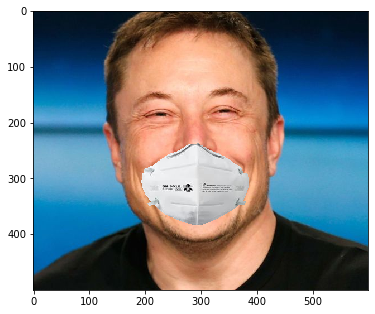

In [8]:
faceWithMaskArithmetic[220:400,170:410] = maskRoiFinal

plt.imshow(faceWithMaskArithmetic[:,:,::-1])

## <font style="color:rgb(50,120,229)">Find the eye region </font>
From the face image, we can see that the eye region lies approximately from row #150 to row #250 and col #140 to col #440. Thus, this will be region where the sunglass is to be placed.

## <font style="color:rgb(50,120,229)">Using Naive Replace</font>
The easiest way that might have come to your mind would be to just replace the eye region with that of the sunglass. Let us give it a try.

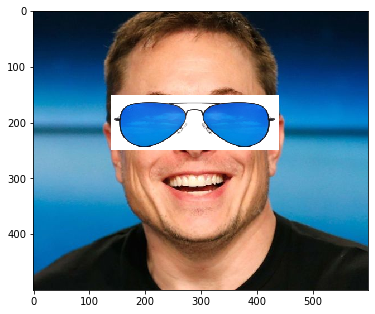

In [9]:
# Make a copy
faceWithGlassesNaive = faceImage.copy()

# Replace the eye region with the sunglass image
faceWithGlassesNaive[150:250,140:440]=glassBGR

plt.imshow(faceWithGlassesNaive[...,::-1])

You can see that the output is not even close. This is because the BGR image is opaque and will either have a black or white rectangle around the sunglass. 

We need to use a mask along with the sunglass image in order to get the desired output. Let us see how it can be done with very simple steps using the tools we have learned till now.

## <font style="color:rgb(50,120,229)">Using Arithmetic Operations and Alpha Mask</font>
In order to put the sunglass on top of the eye region, we need to follow these steps:

1. Create a binary mask with 3-channels using the single channel mask.
1. Extract the eye region from the face image
1. Multiply the Mask with the sunglass to get the masked sunglass
1. Multiply the negative of Mask with the eye region to create a hole in the eye region for the sunglass to be placed.
1. Add the masked sunglass and eye regions to get the combined eye region with the sunglass.
1. Replace the eye region in the original image with that of the output we got in the previous step. This is the final output


Text(0.5, 1.0, 'Augmented Eye and Sunglass')

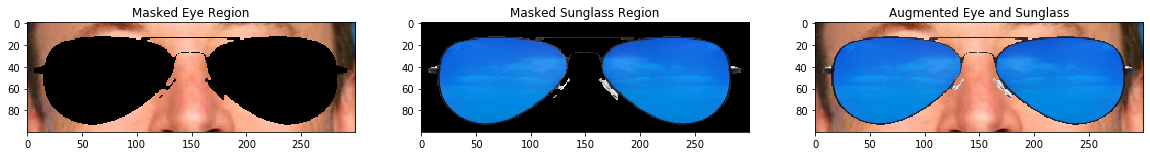

In [10]:
# Make the dimensions of the mask same as the input image.
# Since Face Image is a 3-channel image, we create a 3 channel image for the mask
glassMask = cv2.merge((glassMask1,glassMask1,glassMask1))

# Make the values [0,1] since we are using arithmetic operations
glassMask = np.uint8(glassMask/255)

# Make a copy
faceWithGlassesArithmetic = faceImage.copy()

# Get the eye region from the face image
eyeROI= faceWithGlassesArithmetic[150:250,140:440]

# Use the mask to create the masked eye region
maskedEye = cv2.multiply(eyeROI,(1-glassMask ))

# Use the mask to create the masked sunglass region
maskedGlass = cv2.multiply(glassBGR,glassMask)

# Combine the Sunglass in the Eye Region to get the augmented image
eyeRoiFinal = cv2.add(maskedEye, maskedGlass)

# Display the intermediate results
plt.figure(figsize=[20,20])
plt.subplot(131);plt.imshow(maskedEye[...,::-1]);plt.title("Masked Eye Region")
plt.subplot(132);plt.imshow(maskedGlass[...,::-1]);plt.title("Masked Sunglass Region")
plt.subplot(133);plt.imshow(eyeRoiFinal[...,::-1]);plt.title("Augmented Eye and Sunglass")

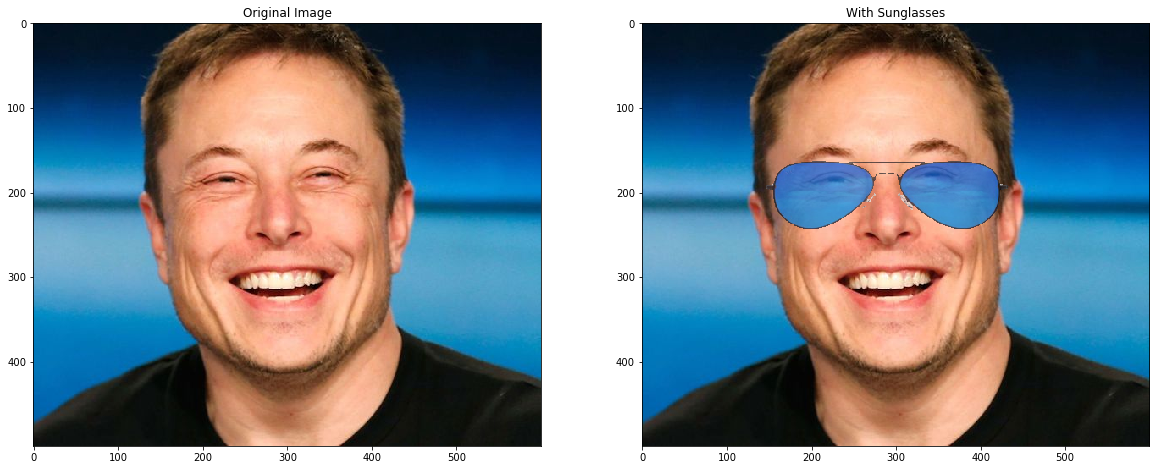

In [13]:
# Replace the eye ROI with the output from the previous section
# faceWithGlassesArithmetic[150:250,140:440]=eyeRoiFinal
faceWithGlassesArithmetic[150:250,140:440]=cv2.addWeighted(eyeRoiFinal,0.5,faceWithGlassesArithmetic[150:250,140:440],0.5,0)
# Display the final result
plt.figure(figsize=[20,20]);
plt.subplot(121);plt.imshow(faceImage[:,:,::-1]); plt.title("Original Image");
plt.subplot(122);plt.imshow(faceWithGlassesArithmetic[:,:,::-1]);plt.title("With Sunglasses");

## <font style="color:rgb(50,120,229)">Exercise</font>
Use the same logic, can you create a similar filter which can augment other objects like ear-rings, mustache etc? Try it out.

You can also try to come up with algorithms to automatically detect the region using computer vision techniques instead of checking the eye region manually.

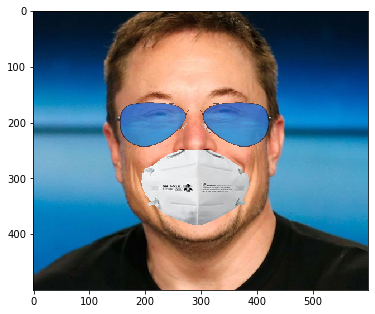

In [15]:
faceWithMaskArithmetic[220:400,170:410] = maskRoiFinal
finalFace = faceWithMaskArithmetic.copy()
finalFace[150:250,140:440]=faceWithGlassesArithmetic[150:250,140:440]

plt.imshow(finalFace[:,:,::-1])